# Model: RNN (Recurrent Natural Network)  - Stock Token: CMG - Test/Train/Vaildation: 70/20/10
- Dataset: 1313 rows x 7 column (01/03/2019 - 01/06/2024)
- Window-slide: 10, epochs: 200, batch-size: 32
----
### Model evaluation (Test set)
- RMSE: 869.4067839959008
- MAE: 651.7954354457171
- MAPE: 1.926241875026581 %

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Dropout, Input

## 1. Data preprocessing


In [2]:
# Split: [0] = 70% 20% 10% | [1] = 60% 20% 20% | [2] = 80% 10% 10%
split_type = [[0.7, 0.2], [0.6, 0.2], [0.8, 0.1]]
# Stock [0] = FPT | [1] = CMG | [2] = ITD
stock_name = ["FPT", "CMG", "ITD"]

In [3]:
# Change stock and split to adjust between splitting type and stock
stock = 1  # CMG
split = 0  # 7 2 1

In [4]:
# Loading data
df = pd.read_csv(f"../../Dataset/{stock_name[stock]}_stock.csv")

df = df[["time", "close"]]
df["time"] = pd.to_datetime(df["time"])
df.set_index("time", inplace=True)

df.head()

,close
time,
2019-03-01,13480
2019-03-04,13970
2019-03-05,14460
2019-03-06,14060
2019-03-07,13830


In [5]:
df.shape

(1313, 1)

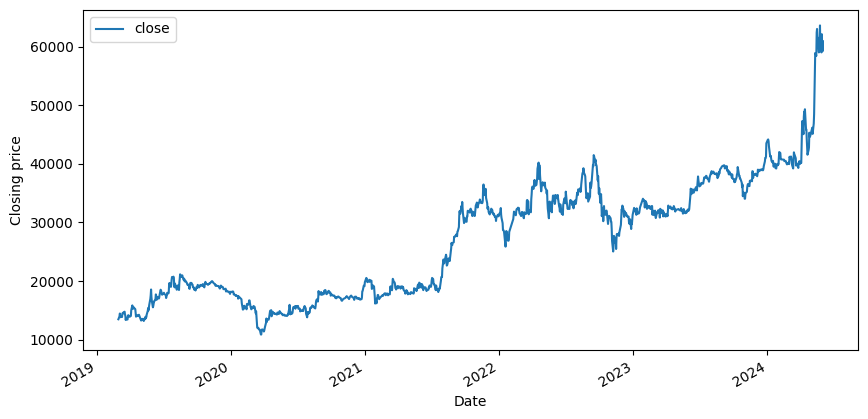

In [6]:
df.plot(figsize=(10, 5))
plt.ylabel("Closing price")
plt.xlabel("Date")
plt.show()

In [7]:
df = df.reset_index()["close"]
df

0       13480
1       13970
2       14460
3       14060
4       13830
        ...  
1308    59000
1309    62100
1310    60000
1311    59200
1312    60900
Name: close, Length: 1313, dtype: int64

In [8]:
# Normalize data between 0 and 1 because we using natural network model
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(np.array(df).reshape(-1, 1))

## 2. Model training


### Create train set, test set, validation set and reshape them

In [9]:
# Defining the split size
train_size = int(split_type[split][0] * len(df_scaled))
test_size = int(split_type[split][1] * len(df_scaled))
val_size = len(df) - train_size - test_size

In [10]:
# Splitting data into train, test and validation set
train_data = df_scaled[:train_size]
test_data = df_scaled[train_size : train_size + test_size]
val_data = df_scaled[train_size + test_size :]

In [11]:
# Function to create dataset input and output, it will convert an array of values into a dataset matrix, use the sliding window with the time_step argument
def create_dataset(data, window_side):
    X, y = [], []

    for i in range(len(data) - window_side - 1):
        X.append(data[i : (i + window_side), 0])
        y.append(data[i + window_side, 0])

    return np.array(X), np.array(y)

In [12]:
# Define time step, it mean the model will take 10 days before to predict the closing price 'at that time'
WINDOW_SIDE = 10

# Create X, y for train, test and validate
X_train, y_train = create_dataset(train_data, WINDOW_SIDE)
X_test, y_test = create_dataset(test_data, WINDOW_SIDE)
X_val, y_val = create_dataset(val_data, WINDOW_SIDE)

X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape

((908, 10), (908,), (251, 10), (251,), (121, 10), (121,))

In [13]:
# Reshape the dataset to suit the RNN input
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)

### Start train model


In [14]:
# Initialize RNN:
model = Sequential(
    [
        Input((X_train.shape[1], 1)),
        SimpleRNN(100),
        Dense(1),
    ]
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 100)            │        10,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,301 (40.24 KB)

 Trainable params: 10,301 (40.24 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# Compile the RNN
model.compile(
    loss="mse",
    optimizer="adam",
    metrics=["mean_absolute_error"],
)

In [16]:
EPOCHS = 200
BATCH_SIZE = 32
VERBOSE = 1

# Fit model with the train dataset
model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=VERBOSE,
)

Epoch 1/200


29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0131 - mean_absolute_error: 0.0774 - val_loss: 4.4922e-04 - val_mean_absolute_error: 0.0163
Epoch 2/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 7.7077e-04 - mean_absolute_error: 0.0203 - val_loss: 4.7130e-04 - val_mean_absolute_error: 0.0167
Epoch 3/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.4620e-04 - mean_absolute_error: 0.0150 - val_loss: 2.7189e-04 - val_mean_absolute_error: 0.0122
Epoch 4/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.7935e-04 - mean_absolute_error: 0.0136 - val_loss: 2.6428e-04 - val_mean_absolute_error: 0.0119
Epoch 5/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.9220e-04 - mean_absolute_error: 0.0120 - val_loss: 2.7411e-04 - val_mean_absolute_error: 0.0122
Epoch 6/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.9220e-04 - mean_absolute_error: 0.0119 - val_loss: 3.2589e-04 - val_mean_absolute_error: 0.0139
Epoch 7/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.8360e-04 - 

### Predicting with test set and validate set

In [17]:
# Predict and convert the data back - because i reshaped between 0 and 1, so need to convert back
y_pred_test = model.predict(X_test)
y_pred_test = scaler.inverse_transform(y_pred_test)

y_pred_val = model.predict(X_val)
y_pred_val = scaler.inverse_transform(y_pred_val)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


## 3. Model evaluation


In [18]:
# Splitting data into train, test and validation set again to evaluate, because i shaped the data between 0 and 1 to suit the model
train_data1 = df[:train_size]
test_data1 = df[train_size : train_size + test_size]
val_data1 = df[train_size + test_size :]

X_test1 = np.array(test_data1.index).reshape(-1, 1)
y_test1 = np.array(test_data1)

X_val1 = np.array(val_data1.index).reshape(-1, 1)
y_val1 = np.array(val_data1)

In [19]:
print(len(y_test))
print(len(y_test1))

251
262


In [20]:
# Evaluation
from sklearn.metrics import (
    mean_absolute_percentage_error as mape,
    mean_squared_error as mse,
    mean_absolute_error as mae,
)

def evalute_model(y, y_pred):
    # Because i use the sliding window with the time_step value, so the length of 'y' and 'y predict' will difference
    min_len = min(len(y), len(y_pred))
    y = y[-min_len:]
    y_pred = y_pred[-min_len:]

    print(f'MSE: {mse(y, y_pred)}')
    print(f'RMSE: {np.sqrt(mse(y, y_pred))}')
    print(f'MAE: {mae(y, y_pred)}')
    print(f'MAPE: {mape(y, y_pred) * 100} %')

In [21]:
# So the result will change every time RUN ALL (build model again), because the model will take random start number.
# But it dont change much, the MAPE will 1.47% ~ 1.8% (test set)
# Model evaluation on test set
print("Model evalution on test set")
evalute_model(y_test1, y_pred_test)

print("")
# Model evaluation on validate set
print("Model evalution on validate set")
evalute_model(y_val1, y_pred_val)

Model evalution on test set
MSE: 755868.1560580949
RMSE: 869.4067839959008
MAE: 651.7954354457171
MAPE: 1.926241875026581 %

Model evalution on validate set
MSE: 4357139.892344072
RMSE: 2087.376317855521
MAE: 1384.1266787190082
MAPE: 2.924820069283885 %


## 4. Predict the next 30/60/90 days


In [22]:
def forecast(data, window_side, forecast_days):
    # Get the last sequence_length days
    x_forecast = data[-window_side:]
    y_forecast = []

    for i in range(forecast_days + 1):
        # Reshape x_forecast to have the shape (1, window_side, num_features)
        x_forecast_reshaped = x_forecast.reshape(1, window_side, x_forecast.shape[1])
        # Predict the next day
        y = model.predict(x_forecast_reshaped)
        y_forecast.append(y[0][0])

        # Add the new prediction to the data
        x_forecast = np.insert(x_forecast, -1, y, axis=0)[1:]

    return y_forecast

In [23]:
y_pred_30_days = forecast(val_data, 5, 30)

# Assuming y_pred_30_days is a 1D array
y_pred_30_days = np.array(y_pred_30_days).reshape(-1, 1)

# Inverse transform y_pred_30_days
y_pred_30_days = scaler.inverse_transform(y_pred_30_days)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 520ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/

In [24]:
y_pred_30_days

array([[62090.63 ],
       [61611.57 ],
       [61960.547],
       [61911.676],
       [61954.016],
       [61948.117],
       [61953.37 ],
       [61952.66 ],
       [61953.312],
       [61953.23 ],
       [61953.32 ],
       [61953.312],
       [61953.324],
       [61953.32 ],
       [61953.324],
       [61953.32 ],
       [61953.332],
       [61953.32 ],
       [61953.332],
       [61953.324],
       [61953.324],
       [61953.324],
       [61953.332],
       [61953.32 ],
       [61953.324],
       [61953.324],
       [61953.324],
       [61953.332],
       [61953.324],
       [61953.324],
       [61953.324]], dtype=float32)

### Continute predict the next 60/90 days

In [25]:
y_pred_60_days = forecast(val_data, 5, 60)
y_pred_60_days = np.array(y_pred_60_days).reshape(-1, 1)
y_pred_60_days = scaler.inverse_transform(y_pred_60_days)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 

In [26]:
y_pred_90_days = forecast(val_data, 5, 90)
y_pred_90_days = np.array(y_pred_90_days).reshape(-1, 1)
y_pred_90_days = scaler.inverse_transform(y_pred_90_days)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━

### Plotting the data

In [27]:
def draw_plot(y_days_predict, days):
    plt.figure(figsize=(10, 6))
    plt.ylabel("Closing Price")

    # Raw data
    plt.plot(train_data1.index, train_data1, label="Train")
    plt.plot(test_data1.index, test_data1, label="Test")
    plt.plot(val_data1.index, val_data1, label="Validate")

    # Predict test and validate
    plt.plot(
        test_data1.index[
            WINDOW_SIDE : len(y_pred_test) + WINDOW_SIDE
        ],  # because using the sliding window (WINDOW_SIDE) -> the index of 2 dataset is difference
        y_pred_test,
        label="Predicted Test",
        linestyle="--",
    )
    plt.plot(
        val_data1.index[WINDOW_SIDE : len(y_pred_val) + WINDOW_SIDE],
        y_pred_val,
        label="Predicted Validate",
        linestyle="--",
    )

    # Predict the next 30/60/90 days
    plt.plot(
        val_data1.index[-1] + np.arange(1, len(y_days_predict) + 1),
        y_days_predict,
        label=f"Predicted Next {days} Days",
        linestyle="--",
    )

    plt.title(f"{stock_name[stock]} Stock Closing Price Prediction Using RNN")
    plt.legend()
    plt.show()

### Predict the closing price next 30/60/90 days

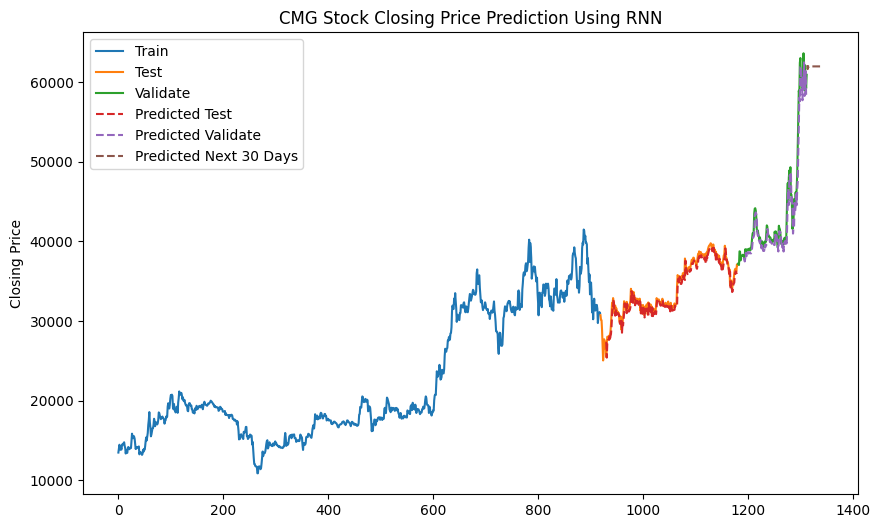

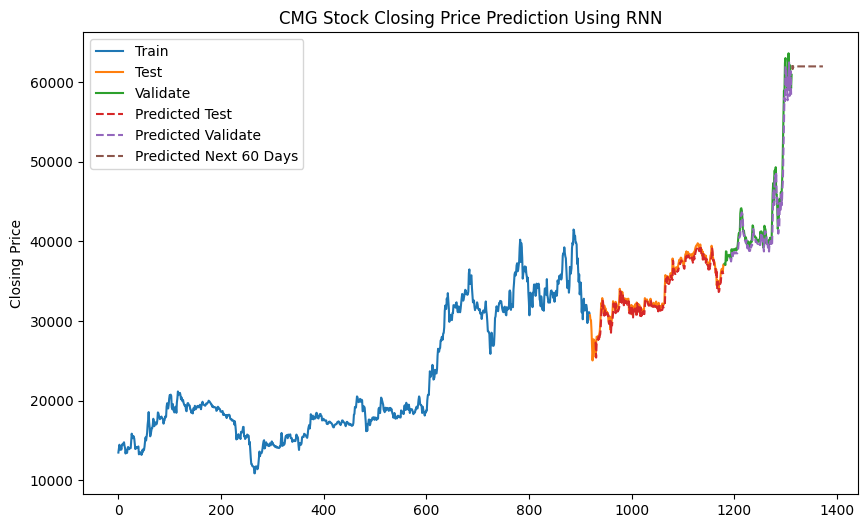

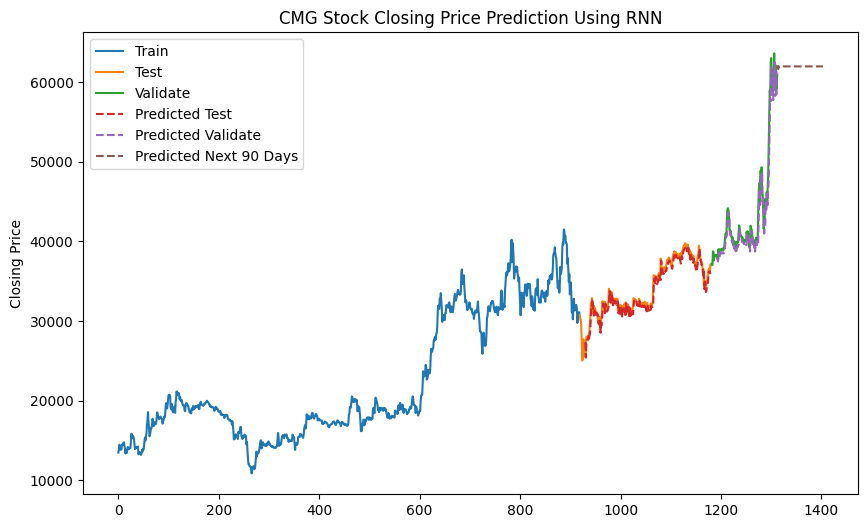

In [28]:
draw_plot(y_pred_30_days, 30)
draw_plot(y_pred_60_days, 60)
draw_plot(y_pred_90_days, 90)